In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import surprise
from surprise.reader import Reader
from surprise.dataset import Dataset
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sp
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tqdm import tqdm
import io
import csv

### Load the Data

In [2]:
ratings = pd.read_csv('data/ratings.csv')

In [3]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100480507 entries, 0 to 100480506
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   movie_id      int64  
 1   user_id       int64  
 2   rating        int64  
 3   date          object 
 4   release_year  float64
 5   movie_name    object 
 6   rating_year   int64  
 7   rating_day    object 
dtypes: float64(1), int64(4), object(3)
memory usage: 6.0+ GB


In [4]:
ratings['date'] = pd.to_datetime(ratings.date)
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100480507 entries, 0 to 100480506
Data columns (total 8 columns):
 #   Column        Dtype         
---  ------        -----         
 0   movie_id      int64         
 1   user_id       int64         
 2   rating        int64         
 3   date          datetime64[ns]
 4   release_year  float64       
 5   movie_name    object        
 6   rating_year   int64         
 7   rating_day    object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 6.0+ GB


In [5]:
ratings.head()

,movie_id,user_id,rating,date,release_year,movie_name,rating_year,rating_day
0,1,1488844,3,2005-09-06,2003.0,Dinosaur Planet,2005,Tuesday
1,1,822109,5,2005-05-13,2003.0,Dinosaur Planet,2005,Friday
2,1,885013,4,2005-10-19,2003.0,Dinosaur Planet,2005,Wednesday
3,1,30878,4,2005-12-26,2003.0,Dinosaur Planet,2005,Monday
4,1,823519,3,2004-05-03,2003.0,Dinosaur Planet,2004,Monday


### Basic Statistics

In [6]:
ratings.rating.astype(int).describe()

count    1.004805e+08
mean     3.604290e+00
std      1.085219e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [7]:
ratings['release_year'].value_counts()

2004.0    10456339
2003.0     9576604
2002.0     8640932
2001.0     7241888
2000.0     6599655
            ...   
1918.0         832
1917.0         662
1914.0         275
1896.0         152
1909.0         109
Name: release_year, Length: 94, dtype: int64

### Movie Title Word Cloud

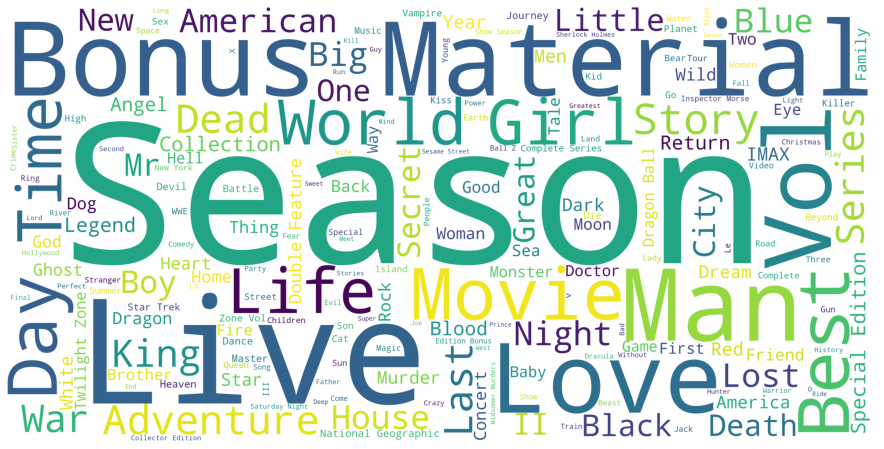

In [8]:
df = pd.DataFrame(ratings[["movie_name"]]).drop_duplicates()
title_corpus = " ".join(df["movie_name"])
title_wordcloud = WordCloud(stopwords = STOPWORDS, background_color = "white", height = 2000, width = 4000).generate(title_corpus)
plt.figure(figsize = (16,8))
plt.imshow(title_wordcloud)
plt.axis("off")
plt.show()

#### Rating Counts

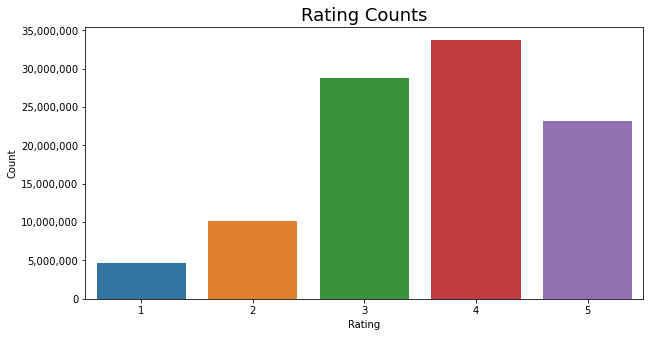

In [9]:
from pylab import *
plt.figure(figsize=(10,5))
sns.countplot(x='rating', data=ratings)
plt.title("Rating Counts", fontsize = 18)
plt.ylabel("Count")
plt.xlabel("Rating")
gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

### Rating Distribution per Movie

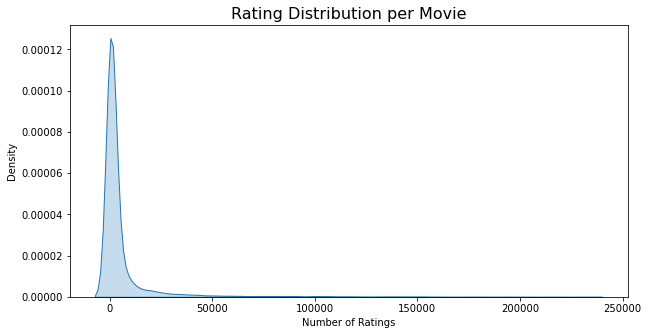

In [10]:
movie_grouped = ratings.groupby('movie_id')['rating'].size().sort_values()

no_of_raitngs = movie_grouped.values

plt.figure(figsize=(10,5))
sns.kdeplot(no_of_raitngs, shade = True)
plt.xlabel('Number of Ratings')
plt.title('Rating Distribution per Movie', fontsize = 16)
plt.show()

### Long Tail Plot

In [11]:
def long_tail_plot(df, item_id_column, interaction_type, percentage=None, x_labels=True):

    """

    Plots the long tail for a user-item interaction dataset.

    ----------

    df: pandas dataframe

        user-item interaction dataframe

        example:

    item_id_column: str

        column name identifying the item ids in the dataframe

    interaction_type: str

        type of user-item interactions

        i.e. 'purchases', 'ratings' 'interactions', or 'clicks'

    percentage: float, default=None

        percent of volume to consider as the head (percent as a decimal)

        (if default=None no line will be plotted)

    x_tables bool, default=True

        if True, plot x-axis tick labels

        if False, no x-axis tick lavels will be plotted.

    Returns:

    -------

        A long tail plot

    """

    #calculate cumulative volumes

    volume_df = df[item_id_column].value_counts().reset_index()

    volume_df.columns = [item_id_column, "volume"]

    volume_df[item_id_column] = volume_df[item_id_column].astype(str)

    volume_df['cumulative_volume'] = volume_df['volume'].cumsum()

    volume_df['percent_of_total_volume'] = volume_df['cumulative_volume']/volume_df['volume'].sum()




    #line plot of cumulative volume

    x=range(0,len(volume_df))

    ax = sns.lineplot(x, y="volume", data=volume_df, color="black")

    plt.xticks(x)




    #set labels

    ax.set_title('Long Tail Plot')

    ax.set_ylabel('# of ' + interaction_type)

    ax.set_xlabel(item_id_column)




    if percentage != None:

        #plot vertical line at the tail location

        head = volume_df[volume_df["percent_of_total_volume"] <= percentage]

        tail = volume_df[volume_df["percent_of_total_volume"] > percentage]

        items_in_head = len(head)

        items_in_tail = len(tail)

        plt.axvline(x=items_in_head, color="red",  linestyle='--')




        # fill area under plot

        head = head.append(tail.head(1))

        x1 = head.index.values

        y1 = head['volume']

        x2 = tail.index.values

        y2 = tail['volume']

        ax.fill_between(x1, y1, color="blue", alpha=0.2)

        ax.fill_between(x2, y2,  color="orange", alpha=0.2)




        #create legend

        legend_elements = [Line2D([0], [0], marker='o', color='w', label=str(items_in_head)+': items in the head', markerfacecolor='blue', markersize=5),

                           Line2D([0], [0], marker='o', color='w', label=str(items_in_tail)+': items in the tail', markerfacecolor='orange', markersize=5)]

        ax.legend(handles=legend_elements, loc=1)




    else:

        x1 = volume_df[item_id_column]

        y1 = volume_df['volume']

        ax.fill_between(x1, y1, color="blue", alpha=0.3)

    if x_labels == False:

        plt.xticks([], [])

        ax.set(xticklabels=[])

    else:

        ax.set_xticklabels(labels = volume_df[item_id_column], rotation = 45, ha="right")




    plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


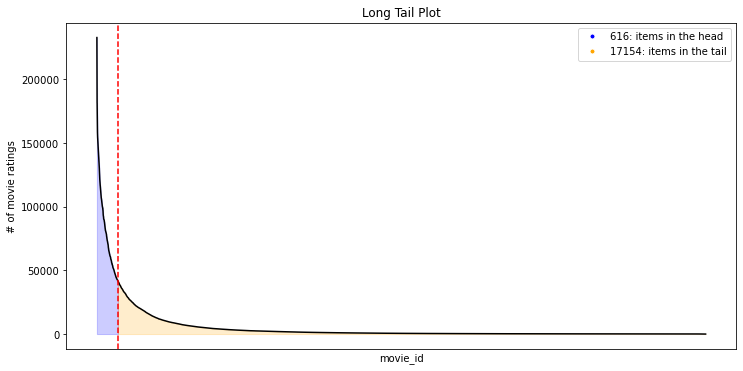

In [12]:
from matplotlib.lines import Line2D
fig = plt.figure(figsize = (12,6))
long_tail_plot(df = ratings, item_id_column = "movie_id", interaction_type = "movie ratings", percentage = 0.5, x_labels = False)

### Rating Distribution by User

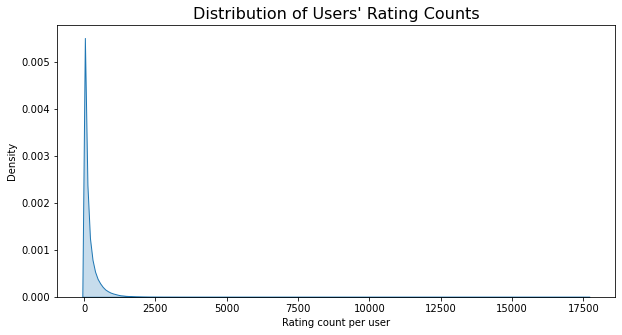

In [13]:
movie_grouped = ratings.groupby('user_id')['rating'].size().sort_values()

plt.figure(figsize=(10,5))
sns.kdeplot(movie_grouped.values, shade = True)
plt.xlabel('Rating count per user')
plt.title("Distribution of Users' Rating Counts", fontsize = 16)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


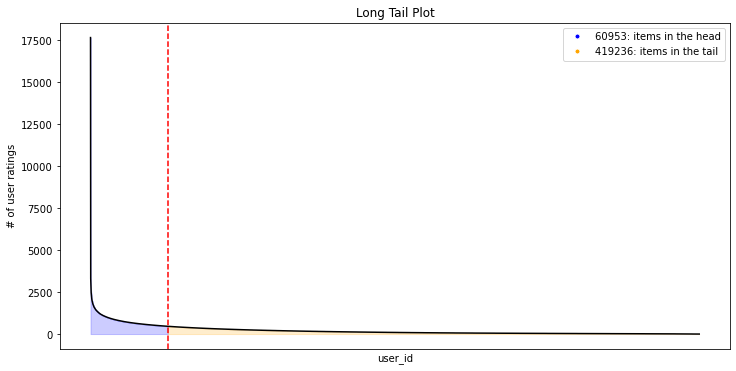

In [14]:
fig = plt.figure(figsize = (12,6))
long_tail_plot(df = ratings, item_id_column = "user_id", interaction_type = "user ratings", percentage = 0.5, x_labels = False)

### Most Rated Movies

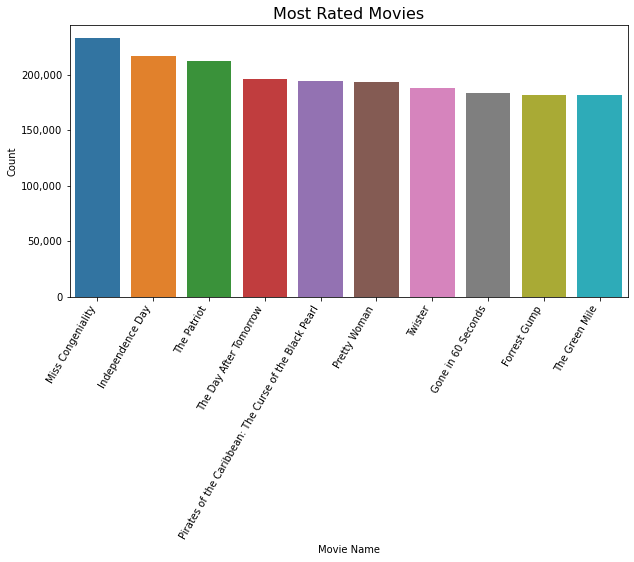

In [15]:
movie_grouped = ratings.groupby('movie_name')['rating'].size().sort_values(ascending = False)
movie_grouped = pd.DataFrame(movie_grouped.values, columns=['Count'], index=movie_grouped.index)

plt.figure(figsize=(10,5))
ax = sns.barplot(x = movie_grouped.index[:10], y='Count', data=movie_grouped[:10])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 60, ha = "right")
gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel("Movie Name")
plt.title("Most Rated Movies", fontsize = 16)
plt.show()

### Least Rated Movies

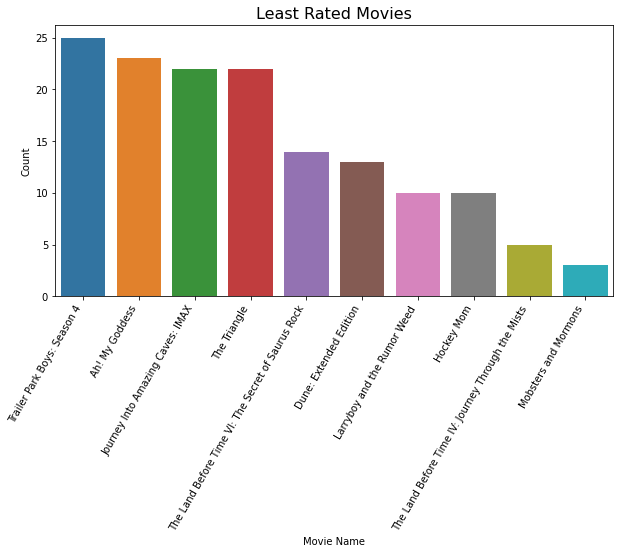

In [16]:
movie_grouped = ratings.groupby('movie_name')['rating'].size().sort_values(ascending = False)
movie_grouped = pd.DataFrame(movie_grouped.values, columns=['Count'], index=movie_grouped.index)

plt.figure(figsize=(10,5))
ax = sns.barplot(x = movie_grouped.index[-10:], y='Count', data=movie_grouped[-10:])
ax.set_xticklabels(ax.get_xticklabels(), rotation = 60, ha = "right")
plt.xlabel("Movie Name")
plt.title("Least Rated Movies", fontsize = 16)
plt.show()

### Average Rating Distribution of Movies

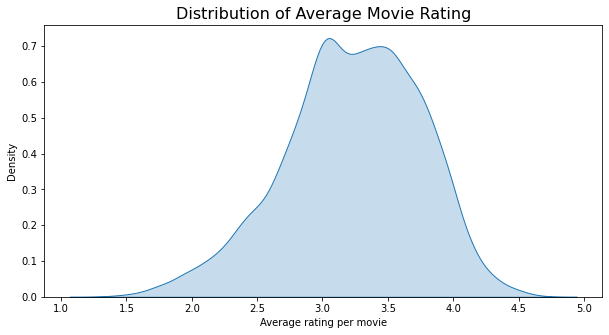

In [17]:
movie_grouped = ratings.groupby('movie_id')['rating'].mean().sort_values()

plt.figure(figsize=(10,5))
sns.kdeplot(movie_grouped.values, shade = True)
plt.xlabel('Average rating per movie')
plt.title('Distribution of Average Movie Rating', fontsize = 16)
plt.show()

### Average Rating Distribution of Users

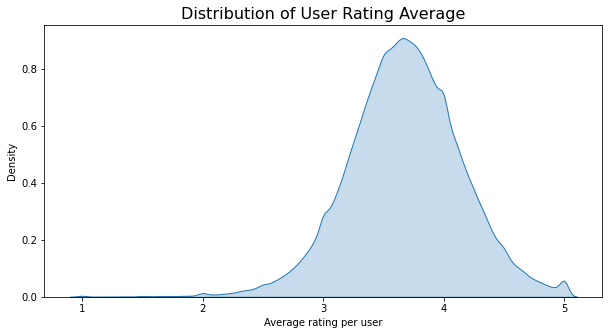

In [18]:
movie_grouped = ratings.groupby('user_id')['rating'].mean().sort_values()

plt.figure(figsize=(10,5))
sns.kdeplot(movie_grouped.values, shade = True)
#sns.kdeplot(movie_grouped.values, cumulative=True)
plt.xlabel('Average rating per user')
plt.title("Distribution of User Rating Average", fontsize= 16)
plt.show()

### Users with most rating counts

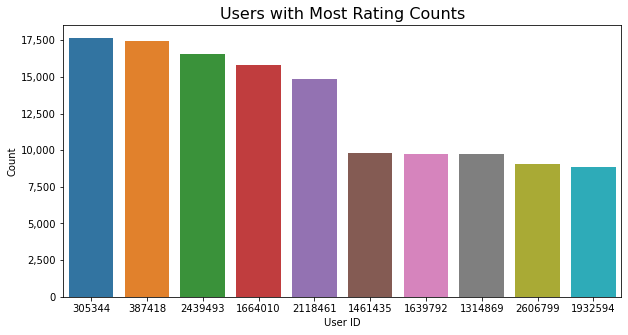

In [19]:
movie_grouped = ratings.groupby('user_id')['rating'].size().sort_values(ascending = False)
movie_grouped = pd.DataFrame(movie_grouped.values, columns=['Count'], index=movie_grouped.index).reset_index()
movie_grouped = movie_grouped[:10]

plt.figure(figsize=(10,5))
sns.barplot(x = movie_grouped["user_id"], y=movie_grouped['Count'], data=movie_grouped, order = movie_grouped["user_id"])
plt.xlabel("User ID")
gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.title("Users with Most Rating Counts", fontsize = 16)
plt.show()

## Users with least rating counts

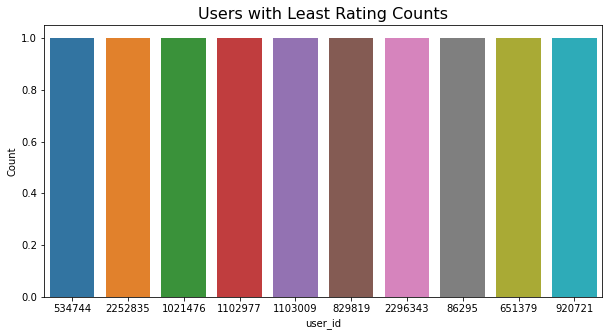

In [20]:
movie_grouped = ratings.groupby('user_id')['rating'].size().sort_values(ascending = False)
movie_grouped = pd.DataFrame(movie_grouped.values, columns=['Count'], index=movie_grouped.index).reset_index()
movie_grouped = movie_grouped[-10:]

plt.figure(figsize=(10,5))
sns.barplot(x = movie_grouped["user_id"], y=movie_grouped['Count'], data=movie_grouped, order = movie_grouped["user_id"])
plt.title("Users with Least Rating Counts", fontsize = 16)
plt.show()

# Analysis based on Years

In [21]:
ratings.head()

,movie_id,user_id,rating,date,release_year,movie_name,rating_year,rating_day
0,1,1488844,3,2005-09-06,2003.0,Dinosaur Planet,2005,Tuesday
1,1,822109,5,2005-05-13,2003.0,Dinosaur Planet,2005,Friday
2,1,885013,4,2005-10-19,2003.0,Dinosaur Planet,2005,Wednesday
3,1,30878,4,2005-12-26,2003.0,Dinosaur Planet,2005,Monday
4,1,823519,3,2004-05-03,2003.0,Dinosaur Planet,2004,Monday


# Rating Count per Year

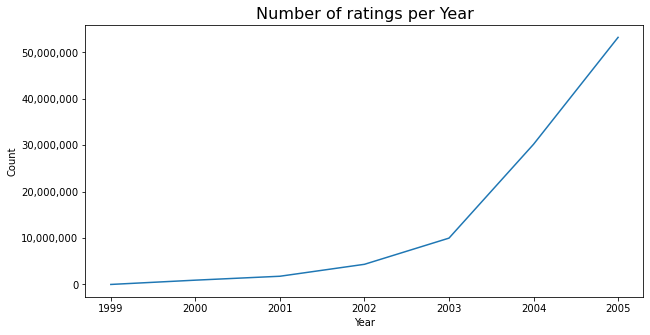

In [22]:
movie_grouped = ratings.groupby('rating_year')['rating'].size().sort_values()
movie_grouped = pd.DataFrame(movie_grouped.values, columns=['Count'], index=movie_grouped.index).reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(y=movie_grouped["Count"], x=movie_grouped["rating_year"])
plt.xlabel('Year')
plt.title("Number of ratings per Year", fontsize= 16)
gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

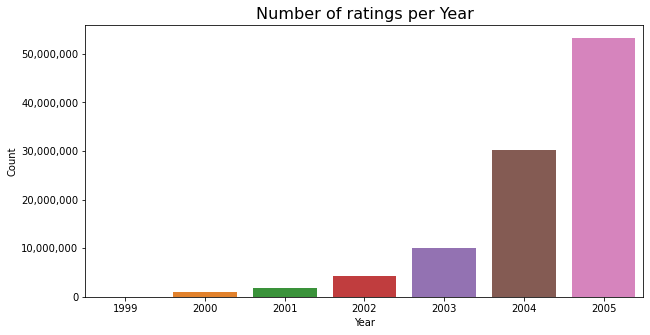

In [23]:
plt.figure(figsize=(10,5))
sns.barplot(y=movie_grouped["Count"], x=movie_grouped["rating_year"])
plt.xlabel('Year')
plt.title("Number of ratings per Year", fontsize= 16)
gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

### Rating Average per Year - Line Chart

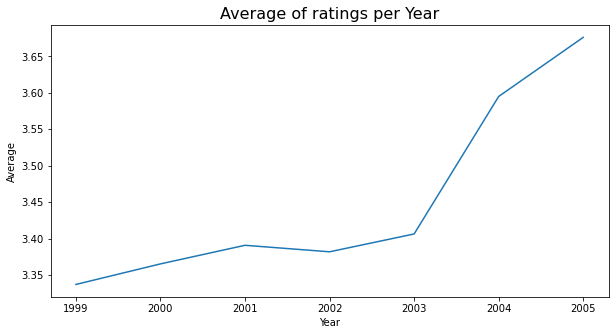

In [24]:
movie_grouped = ratings.groupby('rating_year')['rating'].mean().sort_values()
movie_grouped = pd.DataFrame(movie_grouped.values, columns=['Average'], index=movie_grouped.index).reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(y=movie_grouped["Average"], x=movie_grouped["rating_year"])
plt.xlabel('Year')
plt.title("Average of ratings per Year", fontsize= 16)
plt.show()

### Rating Average per Year - Bar Chart

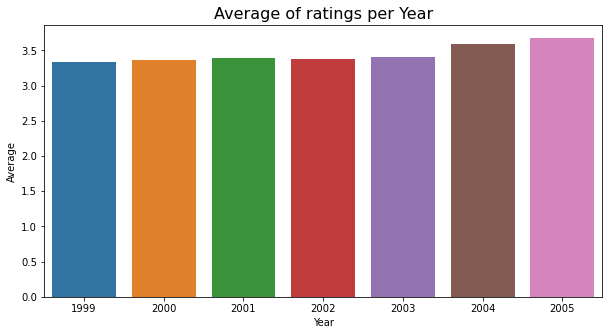

In [25]:
plt.figure(figsize=(10,5))
sns.barplot(y=movie_grouped["Average"], x=movie_grouped["rating_year"])
plt.xlabel('Year')
plt.title("Average of ratings per Year", fontsize= 16)
plt.show()

# Analysis based on Days

In [26]:
ratings.head()

,movie_id,user_id,rating,date,release_year,movie_name,rating_year,rating_day
0,1,1488844,3,2005-09-06,2003.0,Dinosaur Planet,2005,Tuesday
1,1,822109,5,2005-05-13,2003.0,Dinosaur Planet,2005,Friday
2,1,885013,4,2005-10-19,2003.0,Dinosaur Planet,2005,Wednesday
3,1,30878,4,2005-12-26,2003.0,Dinosaur Planet,2005,Monday
4,1,823519,3,2004-05-03,2003.0,Dinosaur Planet,2004,Monday


### Rating Count per Day - Line Chart

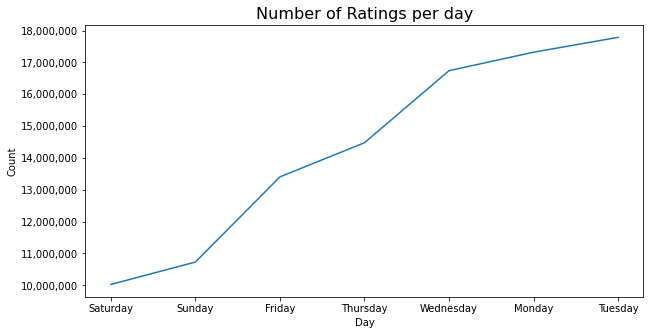

In [27]:
movie_grouped = ratings.groupby('rating_day')['rating'].size().sort_values()
movie_grouped = pd.DataFrame(movie_grouped.values, columns=['Count'], index=movie_grouped.index).reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(y=movie_grouped["Count"], x=movie_grouped["rating_day"])
plt.xlabel('Day')
plt.title("Number of Ratings per day", fontsize = 16)
gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

### Rating Count per Day - Bar Chart

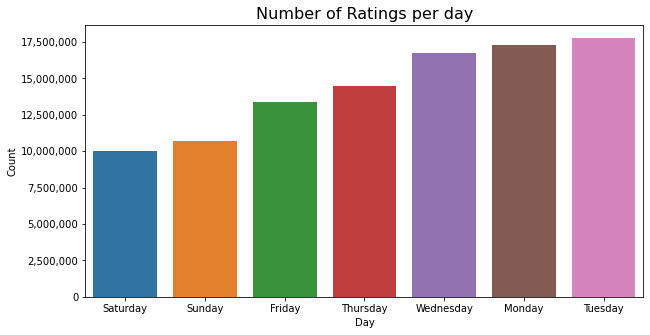

In [28]:
plt.figure(figsize=(10,5))
sns.barplot(y=movie_grouped["Count"], x=movie_grouped["rating_day"])
plt.xlabel('Day')
plt.title("Number of Ratings per day", fontsize = 16)
gca().yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

## Rating Average per Day

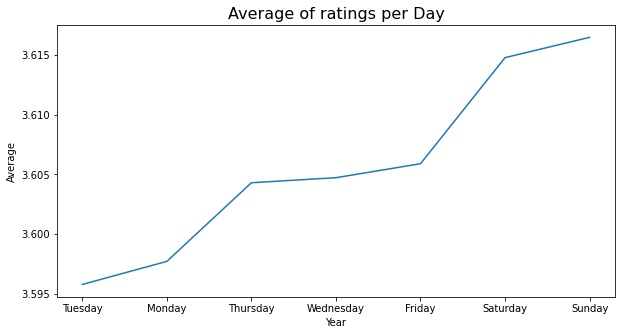

In [29]:
movie_grouped = ratings.groupby('rating_day')['rating'].mean().sort_values()
movie_grouped = pd.DataFrame(movie_grouped.values, columns=['Average'], index=movie_grouped.index).reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(y=movie_grouped["Average"], x=movie_grouped["rating_day"])
plt.xlabel('Year')
plt.title("Average of ratings per Day", fontsize= 16)
plt.show()

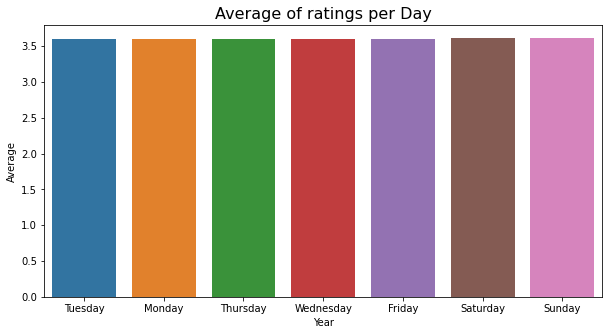

In [30]:
plt.figure(figsize=(10,5))
sns.barplot(y=movie_grouped["Average"], x=movie_grouped["rating_day"])
plt.xlabel('Year')
plt.title("Average of ratings per Day", fontsize= 16)
plt.show()